Simply applying encoding from the sklearn library leads to different codes for a player (team) when it appears in different columns.


1. Only mapping each player (team) to a unique integer, regardless of the column is not good

2. scaling: (CHATGPT:) It is not necessary to use a scaler for categorical features (players and teams) after encoding them with integer values. Scalers are typically used for numerical features to ensure that all features are on the same scale, which can be important for certain machine learning algorithms, particularly those that involve distance calculations or gradient descent optimization. Categorical features that have been encoded with integer values do not require scaling because the integers are used merely as identifiers or labels and do not carry any magnitude or order information. These encoded categorical features are typically treated as discrete variables during model training and inference.



Onehot encoding on the mapped integers is not also good! Since the number of features increases 10 times! Instead we change the data to present_as_home/not-present/present-as-away for each team and player for each row! In this way, we have exactly one column for all teams per row (two of them get the value of 1 and -1 and the rest are 0), and one column for each player per row (5 of them get 1, 5 get -1, and the other ones are 0).


Also Scaling must be applied on only non-categorical features.

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

"""from google.colab import drive


drive.mount('/content/drive')
ds_path = '/content/drive/MyDrive/Data_Mining_Project/Datasets/'"""

ds_path = 'Datasets/'
assert os.path.exists(ds_path)

features = ['outcome', 'season', 'home_team','away_team','starting_min','home_0','home_1','home_2','home_3','home_4','away_0','away_1','away_2','away_3','away_4']
home_players_columns = ['home_0','home_1','home_2','home_3','home_4']
away_players_columns = ['away_0','away_1','away_2','away_3','away_4']


df = pd.DataFrame()
# Load data from matchups-2007.csv to matchups-2011.csv and append them to df
for i in range(2007, 2012):
    df1 = pd.read_csv(ds_path + "matchups-" + str(i) + ".csv")[features]
    print(f"size of the matchup {i} is {len(df1)}")
    df = pd.concat([df, df1])
df.reset_index(drop=True, inplace=True)
print(f"len of final df: {len(df)}")
print("first print \n" + str(df))
print(df.shape)


def encode_teams_names(df):
    global unique_teams
    # Get unique team names
    unique_teams = pd.concat([df['home_team'], df['away_team']]).unique()
    # Initialize a DataFrame with all zeros
    encoded_df = pd.DataFrame(0, index=df.index, columns=unique_teams)
    # Set values for home teams and away teams
    for i in range(df.shape[0]):
      encoded_df.loc[i, df.loc[i, 'home_team']] = 1
      encoded_df.loc[i, df.loc[i, 'away_team']] = -1
    #encoded_df[df['home_team']] = 1 # works incorrect
    #encoded_df[df['away_team']] = -1 # works incorrect
    # Concatenate the encoded team DataFrame with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    # Drop the original home_team and away_team columns
    df = df.drop(['home_team', 'away_team'], axis=1)
    return df


def encode_player_names(df):
    global all_players
    # Get unique player names
    all_players = df[home_players_columns + away_players_columns].stack().unique()
    # Initialize a DataFrame with all zeros
    encoded_df = pd.DataFrame(0, index=df.index, columns=all_players)
    # Set values for home team players and away team players
    for i in range(df.shape[0]):
      encoded_df.loc[i, df.loc[i, home_players_columns]] = 1
      encoded_df.loc[i, df.loc[i, away_players_columns]] = -1
    #encoded_df[df[home_players_columns]] = 1
    #encoded_df[df[away_players_columns]] = -1
    # Concatenate the encoded player DataFrame with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    # Drop the original player columns
    df = df.drop(home_players_columns + away_players_columns, axis=1)
    return df








df = encode_teams_names(df)
print("print after encode teams names \n" + str(df))
#print(df[['LAL', 'PHO', 'MIL', 'CHA']])
df = encode_player_names(df)
print("print after encode players names \n" + str(df))
#print(df[['Smush Parker', 'Boris Diaw', 'Matt Carroll']]) # CHECKED AND CORRECT SO FAR
print(f"size: {df.size}")

X_train = df.drop("outcome", axis=1)
y_train = df["outcome"]


# Feature scaling
columns_to_scale = ['season', 'starting_min']
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

print("print X_train after encoding and scaling \n" + str(X_train))
print()

size of the matchup 2007 is 27500
size of the matchup 2008 is 26593
size of the matchup 2009 is 26407
size of the matchup 2010 is 26344
size of the matchup 2011 is 26447
len of final df: 133291
first print 
        outcome  season home_team away_team  starting_min        home_0  \
0            -1    2007       LAL       PHO             0  Andrew Bynum   
1            -1    2007       LAL       PHO             6  Andrew Bynum   
2             1    2007       LAL       PHO             8    Lamar Odom   
3             1    2007       LAL       PHO            10    Lamar Odom   
4            -1    2007       LAL       PHO            11   Luke Walton   
...         ...     ...       ...       ...           ...           ...   
133286       -1    2011       CHA       MIL            37    Boris Diaw   
133287       -1    2011       CHA       MIL            38    Boris Diaw   
133288       -1    2011       CHA       MIL            39    Boris Diaw   
133289       -1    2011       CHA       MIL

So the number of features increased to 762 + 1 target.

The number of training samples is 133,291. We will use 20% of them for validation during training each model.

Overall, a large number of features is not good, but considering the high number of categorical features and also categories, it is the best possible way.

In [2]:
# Load data from matchups_2012.csv and append it to valid_df
df_valid = pd.read_csv(ds_path + "matchups-2012.csv")[features]

def encode_valid_df_based_on_train(valid_df):
    encoded_df = pd.DataFrame(0, index=valid_df.index, columns=list(unique_teams) + list(all_players))
    for i in range(valid_df.shape[0]):
          encoded_df.loc[i, valid_df.loc[i, home_players_columns + ['home_team']]] = 1
          encoded_df.loc[i, valid_df.loc[i, away_players_columns + ['away_team']]] = -1
    valid_df = pd.concat([valid_df, encoded_df], axis=1)
    # Drop the original player columns
    valid_df = valid_df.drop(home_players_columns + away_players_columns + ['home_team', 'away_team'], axis=1)
    valid_df = valid_df.dropna(axis='columns')
    return valid_df


df_valid = encode_valid_df_based_on_train(df_valid)
X_test = df_valid.drop("outcome", axis=1)
y_test = df_valid["outcome"]


X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
print(X_test)
print(y_test)

         season  starting_min  LAL  PHO  LAC  SAS  UTA  GSW  POR  NJN  ...  \
0      2.125453     -1.895262    0    0    0    0    0    0    0    0  ...   
1      2.125453     -1.433104    0    0    0    0    0    0    0    0  ...   
2      2.125453     -1.356078    0    0    0    0    0    0    0    0  ...   
3      2.125453     -1.202025    0    0    0    0    0    0    0    0  ...   
4      2.125453     -1.047973    0    0    0    0    0    0    0    0  ...   
...         ...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
21236  2.125453      1.031738    0    0    0    0    0    0    0    0  ...   
21237  2.125453      1.185791    0    0    0    0    0    0    0    0  ...   
21238  2.125453      1.339844    0    0    0    0    0    0    0    0  ...   
21239  2.125453      1.416870    0    0    0    0    0    0    0    0  ...   
21240  2.125453      1.647949    0    0    0    0    0    0    0    0  ...   

       James Anderson  Devin Ebanks  Lance Stephenson  Gani Law

The number of test samples is 21241 (and 762 columns), which are from the 2012 dataset.

However, there are some new players and teams...

(array([85405.,     0., 47886.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

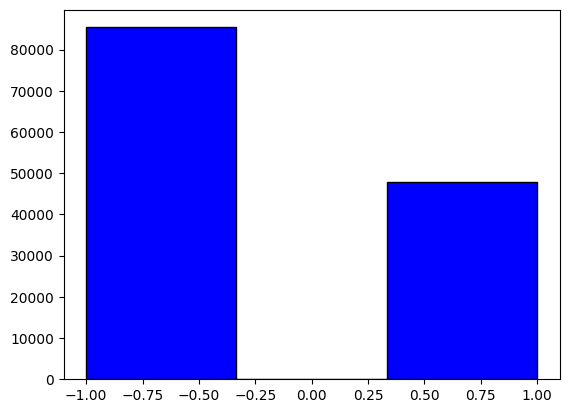

In [3]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=3, color='blue', edgecolor='black')

(array([13454.,     0.,  7787.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

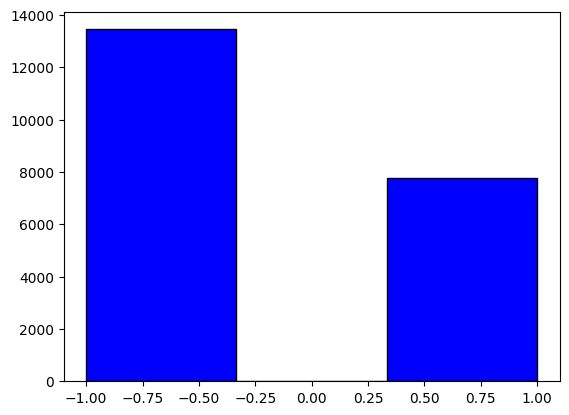

In [4]:
plt.hist(y_test, bins=3, color='blue', edgecolor='black')

Let's try some Neural Networks.

In [5]:
import numpy as np


X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = np.where(y_train == -1, 0.0, 1.0)  # Convert -1 to 0
y_test = np.where(y_test == -1, 0.0, 1.0)    # Convert -1 to 0

print(y_train[:100])

[0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 0.]


In [6]:
X_train_bu = X_train.copy()
X_test_bu = X_test.copy
y_train_bu = y_train.copy()
y_test_bu = y_test.copy()

print(y_train_bu[:3])
print(y_train[:3])

[0. 0. 1.]
[0. 0. 1.]


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

def select_model(num):
    global model
    if num == 1:
        model = Sequential([
                    Dense(512, input_shape=(762,), activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(256, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(128, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])
    elif num == 2:
        model = Sequential([
                    Dense(256, input_shape=(762,), activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(128, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])
    elif num == 3:
        model = Sequential([
                    Dense(256, input_shape=(762,), activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(128, activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])

    elif num == 4:
        model = Sequential([
                    Dense(128, input_shape=(762,), activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    #BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])
    elif num == 5:
        model = Sequential([
                    Dense(128, input_shape=(762,), activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(64, activation='relu'),
                    BatchNormalization(),  # Batch Normalization layer after Dense layer
                    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation
                ])

In [8]:
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from numpy.random import seed
import numpy as np
import shutil

epochs = 20
res_path = 'Results/'
def lr_schedule(epoch):
    """Learning rate schedule function."""
    initial_lr = 0.001
    if epoch < epochs / 4:
        return initial_lr
    else:
        return initial_lr * np.exp(-0.1 * epoch)



def train_NN(mod_num):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    for a_seed in range(100, 111):
        np.random.seed(a_seed)
        seed(a_seed)
        select_model(mod_num)
        
        X_train, X_val, y_train, y_val = train_test_split(X_train_bu, y_train_bu, test_size=0.2, random_state=a_seed)
        
        lr_scheduler = LearningRateScheduler(lr_schedule)
        
        # Compile the model
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall'),
                               tf.keras.metrics.F1Score(name='f1_score', average='macro')])
        
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=False,
                            callbacks=[lr_scheduler])

        loss, accuracy, precision, recall, f1_score = model.evaluate(X_val, y_val)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)


    
    
    # Retrain and Evaluate the model
    # Clear log directory if it exists
    log_dir = "logs_ModelNum" + str(mod_num) + "/fit/"
    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)
    os.makedirs(log_dir)
    sm_checkpoint = tf.keras.callbacks.ModelCheckpoint(res_path + 'checkpoints/best_model_' + str(mod_num) + '.h5', 
                                							monitor='val_f1_score', verbose=0, 
                                							save_best_only=True, mode='max')
    # Define TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    select_model(mod_num)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    
    model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                               tf.keras.metrics.Precision(name='precision'),
                               tf.keras.metrics.Recall(name='recall'),
                               tf.keras.metrics.F1Score(name='f1_score', average='macro')])

    model.summary()
    history = model.fit(X_train_bu, y_train_bu, epochs=epochs, validation_data=(X_test, y_test), verbose=False,
                            callbacks=[tensorboard_callback, lr_scheduler, sm_checkpoint])

    loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
    
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1_score:.4f}')
    print()
    print("From Cross_validation:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f}, std: {np.std(accuracy_list):.4f}")
    print(f"Precision: {np.mean(precision_list):.4f}, std: {np.std(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f}, std: {np.std(recall_list):.4f}")
    print(f"F1-Score: {np.mean(f1_score_list):.4f}, std: {np.std(f1_score_list):.4f}")

    

In [17]:
train_NN(1)

834/834 [==============================] - 2s 2ms/step - loss: 4.6925 - accuracy: 0.5724 - precision: 0.4017 - recall: 0.4022 - f1_score: 0.5611
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 512)               390656    
                                                                 
 dense_111 (Dense)           (None, 256)               131328    
                                                                 
 dense_112 (Dense)           (None, 128)               32896     
                                                                 
 dense_113 (Dense)           (None, 64)                8256      
                                                                 
 dense_114 (Dense)           (None, 1)                 65        
                                                                 
Total params: 563201 (2.15 MB)
Trainable

C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 2ms/step - loss: 5.3557 - accuracy: 0.5588 - precision: 0.4086 - recall: 0.4549 - f1_score: 0.5613
Test Loss: 5.3557
Test Accuracy: 0.5588
Test Precision: 0.4086
Test Recall: 0.4549
Test F1 Score: 0.5613

From Cross_validation:
Accuracy: 0.5729, std: 0.0020
Precision: 0.4040, std: 0.0025
Recall: 0.3917, std: 0.0083
F1-Score: 0.5590, std: 0.0050


In [18]:
train_NN(2)

834/834 [==============================] - 2s 2ms/step - loss: 3.7480 - accuracy: 0.5728 - precision: 0.4015 - recall: 0.3984 - f1_score: 0.5631
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 256)               195328    
                                                                 
 dense_160 (Dense)           (None, 128)               32896     
                                                                 
 dense_161 (Dense)           (None, 64)                8256      
                                                                 
 dense_162 (Dense)           (None, 1)                 65        
                                                                 
Total params: 236545 (924.00 KB)
Trainable params: 236545 (924.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 2ms/step - loss: 3.7299 - accuracy: 0.5630 - precision: 0.4078 - recall: 0.4248 - f1_score: 0.5689
Test Loss: 3.7299
Test Accuracy: 0.5630
Test Precision: 0.4078
Test Recall: 0.4248
Test F1 Score: 0.5689

From Cross_validation:
Accuracy: 0.5732, std: 0.0027
Precision: 0.4052, std: 0.0035
Recall: 0.3959, std: 0.0118
F1-Score: 0.5671, std: 0.0037


In [19]:
train_NN(3)

834/834 [==============================] - 2s 2ms/step - loss: 1.0737 - accuracy: 0.5721 - precision: 0.3973 - recall: 0.3823 - f1_score: 0.5265
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_207 (Dense)           (None, 256)               195328    
                                                                 
 batch_normalization_33 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_208 (Dense)           (None, 128)               32896     
                                                                 
 batch_normalization_34 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_209 (Dense)           (None, 64) 

C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 2ms/step - loss: 0.9889 - accuracy: 0.5766 - precision: 0.4174 - recall: 0.3912 - f1_score: 0.5365
Test Loss: 0.9889
Test Accuracy: 0.5766
Test Precision: 0.4174
Test Recall: 0.3912
Test F1 Score: 0.5365

From Cross_validation:
Accuracy: 0.5747, std: 0.0026
Precision: 0.4039, std: 0.0046
Recall: 0.3807, std: 0.0100
F1-Score: 0.5295, std: 0.0024


In [20]:
train_NN(4)

834/834 [==============================] - 1s 1ms/step - loss: 1.0872 - accuracy: 0.5779 - precision: 0.4004 - recall: 0.3648 - f1_score: 0.5747
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_244 (Dense)           (None, 128)               97664     
                                                                 
 dense_245 (Dense)           (None, 64)                8256      
                                                                 
 dense_246 (Dense)           (None, 1)                 65        
                                                                 
Total params: 105985 (414.00 KB)
Trainable params: 105985 (414.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 1ms/step - loss: 1.1117 - accuracy: 0.5710 - precision: 0.4129 - recall: 0.4034 - f1_score: 0.5744
Test Loss: 1.1117
Test Accuracy: 0.5710
Test Precision: 0.4129
Test Recall: 0.4034
Test F1 Score: 0.5744

From Cross_validation:
Accuracy: 0.5778, std: 0.0028
Precision: 0.4065, std: 0.0051
Recall: 0.3747, std: 0.0075
F1-Score: 0.5775, std: 0.0022


In [9]:
train_NN(5)

834/834 [==============================] - 1s 1ms/step - loss: 0.8881 - accuracy: 0.5754 - precision: 0.3957 - recall: 0.3576 - f1_score: 0.5265
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               97664     
                                                                 
 batch_normalization_22 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_23 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_35 (Dense)            (None, 1)  

C:\Python-3.11.4\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


664/664 [==============================] - 1s 2ms/step - loss: 0.8238 - accuracy: 0.5757 - precision: 0.4118 - recall: 0.3677 - f1_score: 0.5365
Test Loss: 0.8238
Test Accuracy: 0.5757
Test Precision: 0.4118
Test Recall: 0.3677
Test F1 Score: 0.5365

From Cross_validation:
Accuracy: 0.5772, std: 0.0040
Precision: 0.4048, std: 0.0053
Recall: 0.3706, std: 0.0109
F1-Score: 0.5295, std: 0.0024
